In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
confusion_matrix, roc_curve, roc_auc_score, classification_report
)


import seaborn as sns
sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
d

In [4]:
df = df.copy()

In [5]:
import re


def extract_title(name):
    m = re.search(r",\s*([^\.]+)\.", name)
    return m.group(1).strip() if m else ''


df['Title'] = df['Name'].apply(extract_title)


# Simplify titles
title_map = {
'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
'Lady': 'Rare', 'Countess': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Jonkheer': 'Rare',
'Capt': 'Rare', 'Col': 'Rare', 'Dr': 'Rare', 'Major': 'Rare'
}


df['Title'] = df['Title'].replace(title_map)


# Family size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


# Drop columns that are less useful or too sparse
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)


df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,1,female,38.0,1,0,71.2833,C,Mrs,2
2,1,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2
4,0,3,male,35.0,0,0,8.0500,S,Mr,1


Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


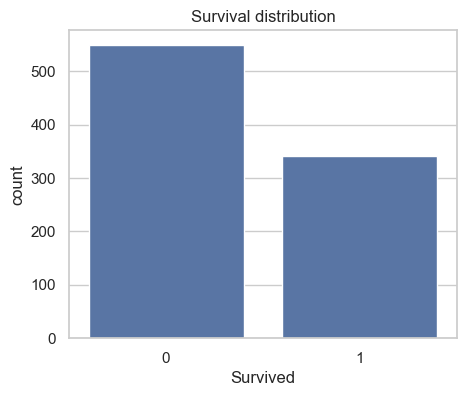

In [6]:
print(df['Survived'].value_counts(normalize=True))
plt.figure(figsize=(5,4))
sns.countplot(x='Survived', data=df)
plt.title('Survival distribution')
plt.show()

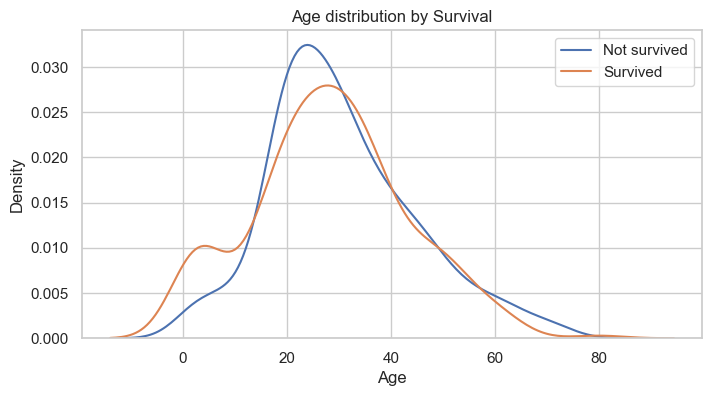

In [ ]:
plt.figure(figsize=(8,4))
sns.kdeplot(df.loc[df['Survived']==0,'Age'].dropna(), label='Not survived') #type:ignore
sns.kdeplot(df.loc[df['Survived']==1,'Age'].dropna(), label='Survived')#type:ignore
plt.title('Age distribution by Survival')
plt.legend()
plt.show()

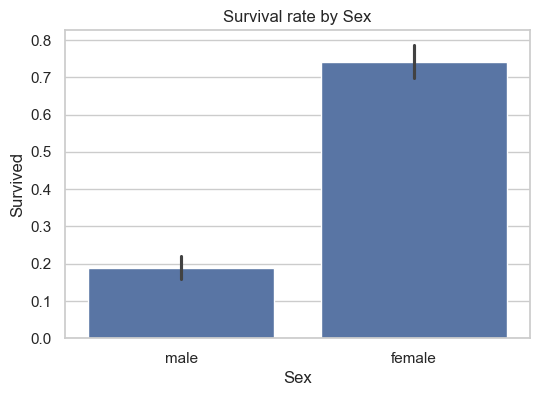

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival rate by Sex')
plt.show()

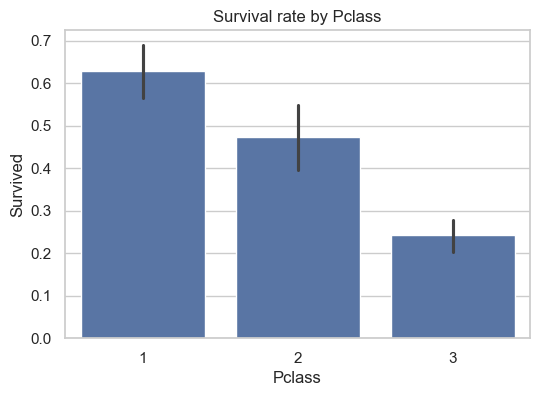

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival rate by Pclass')
plt.show()

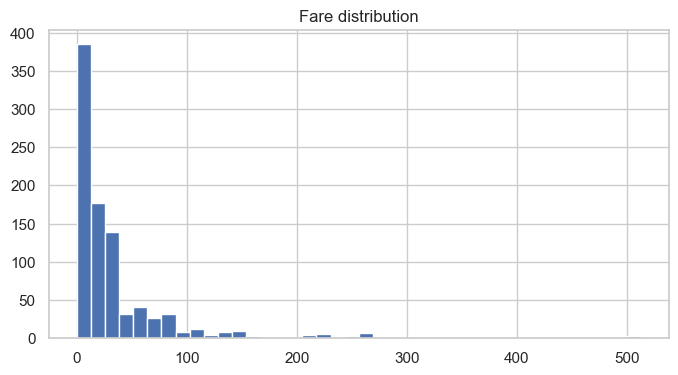

In [10]:
plt.figure(figsize=(8,4))
plt.hist(df['Fare'].dropna(), bins=40)
plt.title('Fare distribution')
plt.show()

In [12]:
age_medians = df.groupby('Title')['Age'].median()


# Fill Age where possible
for t, m in age_medians.items():
    df.loc[(df['Age'].isnull()) & (df['Title'] == t), 'Age'] = m


# Remaining missing Age -> fill overall median
df['Age'] = df['Age'].fillna(df['Age'].median())
# Embarked
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
# Fare
df['Fare'] = df['Fare'].fillna(df['Fare'].median())


# Convert Title to categorical grouping (ensure limited categories)
print(df['Title'].value_counts())

Title
Mr              517
Miss            185
Mrs             126
Master           40
Rare             16
Rev               6
the Countess      1
Name: count, dtype: int64


In [13]:
X = df.drop('Survived', axis=1)
y = df['Survived']


# Identify numeric and categorical features
numeric_features = ['Age', 'Fare', 'FamilySize', 'SibSp', 'Parch', 'Pclass']
cat_features = ['Sex', 'Embarked', 'Title']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print(X_train.shape, X_val.shape)

(712, 9) (179, 9)


In [14]:
numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])


cat_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, numeric_features),
('cat', cat_transformer, cat_features)
]
)


rf = RandomForestClassifier(random_state=42)


pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])

In [15]:
param_grid = {
'classifier__n_estimators': [100, 200],
'classifier__max_depth': [None, 5, 10],
'classifier__min_samples_split': [2, 5],
}


grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


print('Best params:', grid.best_params_)
print('Best CV score (F1):', grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV score (F1): 0.7591783967255665


In [16]:
best_model = grid.best_estimator_


y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:,1]


print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1-score:', f1_score(y_val, y_pred))


print('\nClassification report:\n')
print(classification_report(y_val, y_pred))

Accuracy: 0.8268156424581006
Precision: 0.796875
Recall: 0.7391304347826086
F1-score: 0.7669172932330827

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



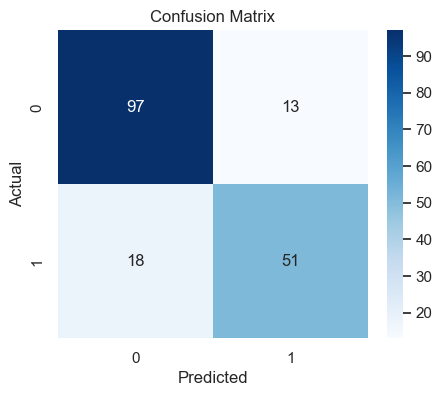

In [17]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

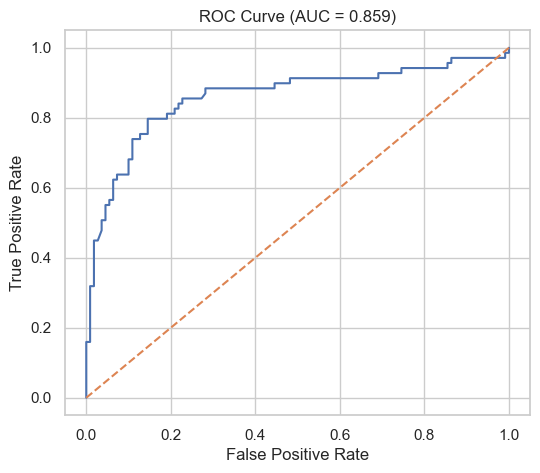

In [18]:
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc = roc_auc_score(y_val, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc:.3f})')
plt.show()

<Figure size 800x600 with 0 Axes>

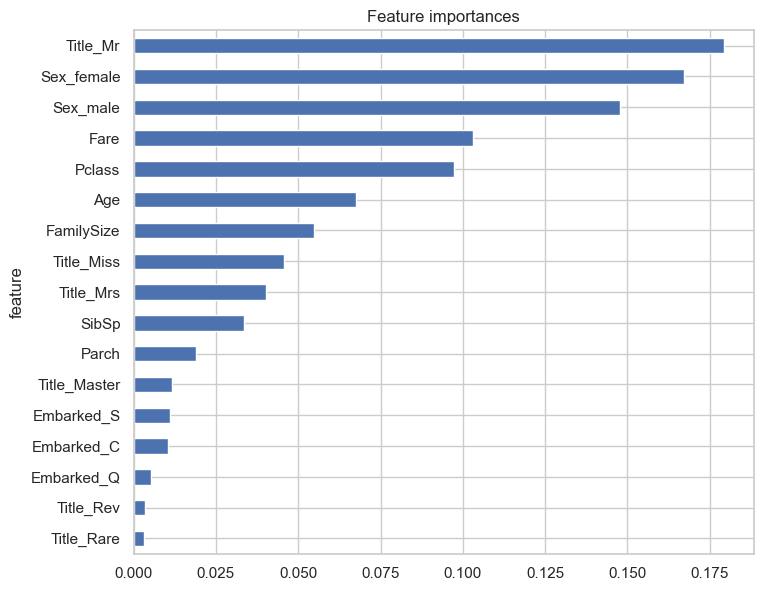

In [21]:
def plot_feature_importances(importances, features, top_n=15, ax=None):
    df = pd.DataFrame({'feature': features, 'importance': importances})
    df = df.sort_values('importance', ascending=False).head(top_n)
    ax = df.plot.barh(x='feature', y='importance', legend=False, figsize=(8, max(2, 0.4*len(df))))
    ax.invert_yaxis()
    plt.title('Feature importances')
    return ax
onehot_columns = list(grid.best_estimator_.named_steps['preprocessor']
.named_transformers_['cat']
.named_steps['onehot'].get_feature_names_out(cat_features))
all_features = numeric_features + onehot_columns
importances = grid.best_estimator_.named_steps['classifier'].feature_importances_


plt.figure(figsize=(8,6))
plot_feature_importances(importances, all_features, top_n=20)
plt.show()

In [22]:
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))])


dt_params = {'classifier__max_depth':[None,5,10], 'classifier__min_samples_split':[2,5]}


dt_grid = GridSearchCV(dt_pipe, dt_params, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train, y_train)


print('Decision Tree best params:', dt_grid.best_params_)
print('Decision Tree CV F1:', dt_grid.best_score_)


# Evaluate
y_pred_dt = dt_grid.predict(X_val)
print('Decision Tree Accuracy:', accuracy_score(y_val, y_pred_dt))
print('Decision Tree F1:', f1_score(y_val, y_pred_dt))

Decision Tree best params: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Decision Tree CV F1: 0.7132741009171216
Decision Tree Accuracy: 0.8044692737430168
Decision Tree F1: 0.7107438016528925


In [24]:
f"""
Summary (deliverable):


- Best hyperparameters found for Random Forest (example):
- n_estimators: {grid.best_params_['classifier__n_estimators']}
- max_depth: {grid.best_params_['classifier__max_depth']}
- min_samples_split: {grid.best_params_['classifier__min_samples_split']}


- Most important features (top 5): list shown in the feature importance plot.


- Performance:
- Accuracy: (print above)
- Precision/Recall/F1: (see classification report)
- AUC: (see ROC plot)


- Strengths of Random Forest on Titanic dataset:
- Robust to outliers and mixed feature types.
- Handles non-linear interactions and feature importance easily interpretable.


- Limitations:
- Not great with very small data for complex hyperparameter tuning — risk of overfitting.
- Some features (like Name/Cabin) were dropped; more advanced feature engineering could help.


Conclude with suggestions for future work: cross-validation with more folds, try XGBoost/LightGBM, more features (deck from cabin), target encoding for Titles, etc
"""

'\nSummary (deliverable):\n\n\n- Best hyperparameters found for Random Forest (example):\n- n_estimators: 200\n- max_depth: 5\n- min_samples_split: 5\n\n\n- Most important features (top 5): list shown in the feature importance plot.\n\n\n- Performance:\n- Accuracy: (print above)\n- Precision/Recall/F1: (see classification report)\n- AUC: (see ROC plot)\n\n\n- Strengths of Random Forest on Titanic dataset:\n- Robust to outliers and mixed feature types.\n- Handles non-linear interactions and feature importance easily interpretable.\n\n\n- Limitations:\n- Not great with very small data for complex hyperparameter tuning — risk of overfitting.\n- Some features (like Name/Cabin) were dropped; more advanced feature engineering could help.\n\n\nConclude with suggestions for future work: cross-validation with more folds, try XGBoost/LightGBM, more features (deck from cabin), target encoding for Titles, etc\n'